<a href="https://colab.research.google.com/github/AbbasHussain72/GANSUB/blob/main/WGAN_Submarine_Data_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import tensorflow as tf
# print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is NOT available")


In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print('GPU device not found. Running on CPU.')
# else:
#   print('Found GPU at: {}'.format(device_name))

In [ ]:
import sys
import sklearn
from sklearn.preprocessing import *
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import time
import functools
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
import keras
from keras import Input, Model
from keras.layers import Dense, LeakyReLU, concatenate
from keras.models import Model
from keras.layers import Input, Reshape
# from keras.layers.core import Dense, Activation, Dropout, Flatten
# from keras.layers.normalization import BatchNormalization
# from keras.layers.convolutional import UpSampling1D, Conv1D
# from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard
tf.keras.layers.LeakyReLU(alpha=0.2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load the file
# path = r'C:\Users\Dr.Abbas\OneDrive - National University of Sciences & Technology\Aerodynamics ML data\original_data'
filename = "Submarine_data_without.csv"
pathfull = path + filename

data1 = pd.read_csv(pathfull)

# Separating out features
data1 = data1.drop(['V ', 'AOA ','SA '],axis = 1)

#Transform the data
scaler = StandardScaler()
scaler.fit(data1)
data = scaler.transform(data1)

#load transform data into dataframe
df = pd.DataFrame(data, columns=data1.columns)
print(df.shape)

(585, 3)


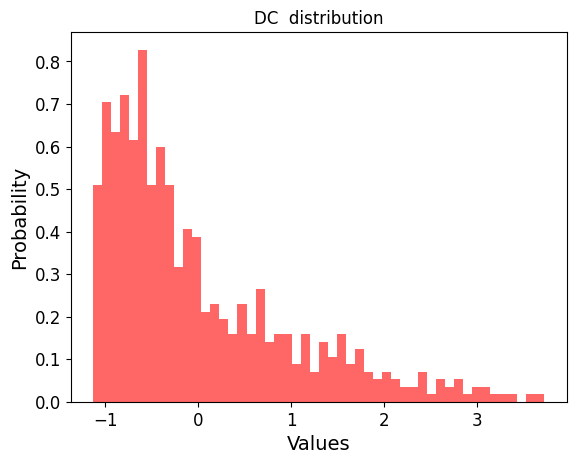

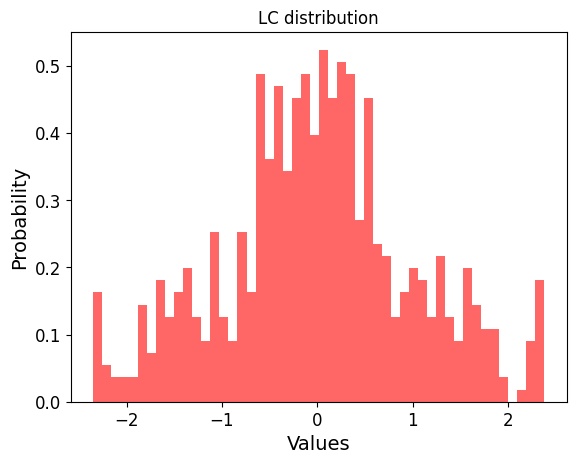

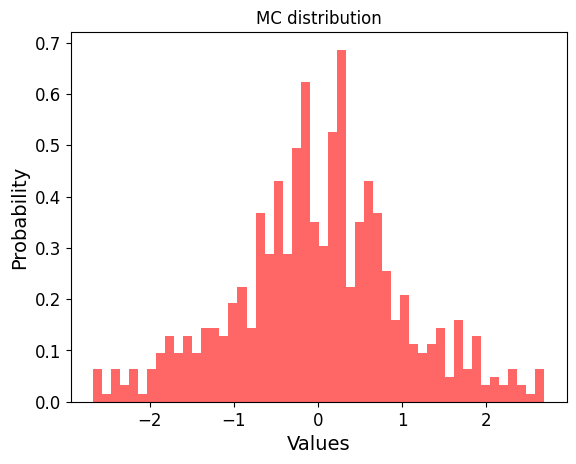

<Figure size 640x480 with 0 Axes>

In [ ]:
for name in df.columns:
    plt.xlabel('Values')
    plt.ylabel('Probability')
    plt.title(name + " distribution")
    #Collecting corresponding class values where the Outcome is 0/1 (Color red being 1 and blue being 0)
    dist = df[name].values
    plt.hist(dist, 50, density=True, alpha=0.6, facecolor='r')
#     plt.savefig('img/' + name + 'distribution.png')
    plt.show()
    plt.clf()

# Parameters and Architecture for WGAN-GP

In [ ]:
#Parameters
len_class = df.shape[1]                     #output from generator and input to critic (discriminator)
out_feature = 1                             #output from the discriminator usually its binary
# BATCH_SIZE = [[32],[64],[15],[128]]
BATCH_SIZE = [[64]]
latent_space = 100                         #input to generator
n_critic = 5
num_examples_to_generate = 1
GPH = 10.0                                  #Gradient Penalty Hyperparameter
h_g = [[10,30]]
h_d = [[128,256]]
lr = [[0.00002]]
drp = [0.2]
epoch = [10000]


#ARCHITECTURE-------------------------------------------------------------------------------------------------
class Architecture():
    def __init__(self, learning_rate, batch_size, hidden_layers_gen,hidden_layers_dis,name):
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        self.hidden_layers_gen =hidden_layers_gen
        self.hidden_layers_dis =hidden_layers_dis
        self.name=name

#Creating Architecture-----------------------------------------------------------------------------------
#Only entity being changed here is the hidden_layer array and the number of experiment
architectures=[]
count=0
for l in lr:
    for b_size in BATCH_SIZE:
        for hiddengen in h_g:
            for hiddendis in h_d:
                for i in range(num_examples_to_generate):
                    name = "id-" + str(count)
                    name += "_epochs-" + str(epoch[0])
                    name += "_lr-" + str(l[0])
                    name += "_batch-" + str(b_size[0])
                    name += "_arcgen-" + ','.join(map(str, hiddengen))
                    name += "_arcdis-" + ','.join(map(str, hiddendis))
                    name += "_ncritic-" + str(n_critic)
                    architectures.append( Architecture(
                            learning_rate=l[0],
                            batch_size=b_size[0],
                            hidden_layers_gen=hiddengen,
                            hidden_layers_dis=hiddendis,
                            name=name
                    )
                )
                    count+=1

#Print the number of architecture-------------------------------------------------------------------------------
num=0
for arc in architectures:
    print(arc.name)
    num+=1
print(num)

id-0_epochs-10000_lr-2e-05_batch-64_arcgen-10,30_arcdis-128,256_ncritic-5
1


# Make models for WGAN

In [ ]:
import tensorflow as tf
from tensorflow import keras
#----------------------------------------------------------------------------------------------
# sa='/content/drive/MyDrive/GAN_NEW/done/'+ arc.name +'.h5'

def make_generator_model(hidden_layers, activations, input_shape, output_shape):
    model = tf.keras.Sequential(name="Generator_model")

    for i in range(len(hidden_layers)):
        units = hidden_layers[i]
        activation = activations
        input_fea = input_shape
        output_fea = output_shape
        if i == 0 and input_fea is not None:
            # Define input shape for the first layer
            model.add(tf.keras.layers.Dense(units, activation=activation,kernel_initializer='he_uniform',use_bias=False, input_dim =input_fea ))
            # model.add(tf.keras.layers.BatchNormalization())
        else:
            model.add(tf.keras.layers.Dense(units, activation=activation))

    model.add(tf.keras.layers.LayerNormalization())

    # Add the last layer with output shape and linear activation
    if output_fea is not None:
        model.add(tf.keras.layers.Dense(output_fea,use_bias=False, activation='linear'))

    return model
#--------------------------------------------------------------------------------------------------------
def make_discriminator_model(hidden_layers, activations, input_shape, output_shape):
    model = tf.keras.Sequential(name="Discriminator_model")

    for i in range(len(hidden_layers)):
        units = hidden_layers[i]
        activation = activations
        input_fea = input_shape
        output_fea = output_shape
        if i == 0 and input_fea is not None:
            # Define input shape for the first layer
            model.add(tf.keras.layers.Dense(units, activation=activation,kernel_initializer='he_uniform',input_dim =input_fea))
            model.add(keras.layers.LayerNormalization())
        else:
            model.add(tf.keras.layers.Dense(units, activation=activation))
            model.add(keras.layers.LayerNormalization())


    # Add the last layer with output shape and linear activation
    if output_fea is not None:
        model.add(tf.keras.layers.Dense(output_fea,activation='sigmoid'))

    return model

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output,fake_output):
    return tf.reduce_mean(fake_output)-tf.reduce_mean(real_output)

def gradient_penalty(f, real, fake):

    def _interpolate(a, b):
        shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
        alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
        a = tf.cast(a, tf.float32)
        b = tf.cast(b, tf.float32)
        alpha = tf.cast(alpha, tf.float32)
        inter = a + alpha * (b - a)
        inter.set_shape(a.shape)
        return inter

    x = _interpolate(real, fake)
    with tf.GradientTape() as t:
        t.watch(x)
        pred = f(x)
    grad = t.gradient(pred, x)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)

    return gp

@tf.function
def train_G(batch):
    with tf.GradientTape() as gen_tape:
        if batch.shape[0]==arc.batch_size:
            noise = tf.random.normal([arc.batch_size, latent_space])
        else:
            noise = tf.random.normal([batch.shape[0]%arc.batch_size, latent_space])
        generated_data = generator(noise, training=True)
        fake_output = discriminator(generated_data, training=True)
        gen_loss = generator_loss(fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


    return gen_loss

@tf.function
def train_D(batch):
    with tf.GradientTape() as disc_tape:
        if batch.shape[0]==arc.batch_size:
            noise = tf.random.normal([arc.batch_size, latent_space])
        else:
            noise = tf.random.normal([batch.shape[0]%arc.batch_size, latent_space])

        generated_data = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss_without = discriminator_loss(real_output, fake_output)
        gp = gradient_penalty(functools.partial(discriminator, training=True), batch, generated_data)
        disc_loss = discriminator_loss(real_output, fake_output) + gp*10.0

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss_without

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

seed = tf.random.normal([num_examples_to_generate, latent_space])

#log the result
generator_log_dir = "/content/drive/MyDrive/GAN_NEW/generator"
discriminator_log_dir = "/content/drive/MyDrive/GAN_NEW/discriminator"

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)


#Training____________________________________________________________________
def plotl(hs):
  print('Loss: ')
  fig, ax = plt.subplots(1,1, figsize=[10,5])
  ax.plot(hs)
  ax.legend(['loss_gen', 'loss_disc'])
  #ax.set_yscale('log')
  ax.grid()
  plt.show()



def train(dataset,generator,discriminator,gan, epochs):
    # Split dataset into batches
    train_dataset = tf.data.Dataset.from_tensor_slices(dataset )
    train_dataset = train_dataset.shuffle(len(dataset))
    train_dataset = train_dataset.batch(arc.batch_size)
    num=0

    sa='/content/drive/MyDrive/GAN_NEW/done/'+ arc.name +'.h5'

    def has_nan(tensor):
        return tf.reduce_any(tf.math.is_nan(tensor))

    hist = []
    for epoch in range(epochs):
        start = time.time()
        if epoch % 500 == 0 :
          print("Epoch {}/{}".format(epoch + 1, epochs))

        for batch in train_dataset:

            for _ in range(n_critic):
                disc_loss_without = train_D(batch)

                # Check for NaN values in discriminator loss
                if has_nan(disc_loss_without):
                    print("NaN values detected in discriminator loss. Stopping training.")
                    plotl(hist)
                    gan.save(sa)
                    return hist


            gen_loss = train_G(batch)

            # Check for NaN values in generator loss
            if has_nan(gen_loss):
                print("NaN values detected in generator loss. Stopping training.")
                plotl(hist)
                gan.save(sa)
                return hist


            generator_mean_loss(gen_loss)
            discriminator_mean_loss(disc_loss_without)

        with generator_summary_writer.as_default():
            tf.summary.scalar('generator_loss', generator_mean_loss.result(), step=epoch)

        with discriminator_summary_writer.as_default():
            tf.summary.scalar('discriminator_loss', discriminator_mean_loss.result(), step=epoch)

        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()

        if epoch % 500 == 0 :
          print("discriminator: {:.6f}".format(hist[-1][1]), end=' - ')
          print("generator: {:.6f}".format(hist[-1][0]), end=' - ')
          print('{:.0f}s'.format( time.time()-start))
    plotl(hist)
        #save the model
    gan.save(sa)
    return hist

In [ ]:
gan.save('/content/drive/MyDrive/GAN_NEW/done/'+ arc.name +'.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# RUN THE MODEL

In [ ]:
%matplotlib inline
for arc in architectures:
        print(arc.name)
        # generator_output_shape = (len_class,)  # Replace with your desired output shape
        generator = make_generator_model(arc.hidden_layers_gen, activations = 'LeakyReLU',input_shape=latent_space, output_shape=len_class)
        generator.summary()
        discriminator = make_discriminator_model(arc.hidden_layers_dis, activations = 'LeakyReLU',input_shape=len_class, output_shape=out_feature )
        discriminator.summary()
        gan = keras.models.Sequential([generator, discriminator])
        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=arc.learning_rate, beta_1=0.5, beta_2=0.999)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=arc.learning_rate, beta_1=0.5, beta_2=0.999)
#         gan.summary()
        hist = train(df,generator,discriminator,gan, epochs=epoch[0])

id-0_epochs-10000_lr-2e-05_batch-64_arcgen-10,30_arcdis-128,256_ncritic-5
Model: "Generator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1000      
                                                                 
 dense_1 (Dense)             (None, 30)                330       
                                                                 
 layer_normalization (Layer  (None, 30)                60        
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 3)                 90        
                                                                 
Total params: 1480 (5.78 KB)
Trainable params: 1480 (5.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Dis

KeyboardInterrupt: ignored

# Analyze the model


In [ ]:
num_samples = 585
latent_dim = 100
import os
# Define the folder where your models are stored
model_folder = '/content/drive/MyDrive/GAN_NEW/done/'
# List all files in the folder
model_files = os.listdir(model_folder)
# Iterate through each model file and load it
for model_file in model_files:
    if model_file.endswith('.h5'):  # Assuming your models have a '.h5' extension
        model_path = os.path.join(model_folder, model_file)
        print("Loading model:", model_path)
        f_name = model_path.split("/")[-1][:-3]
        full = f_name + ".csv"
        loaded_gan = tf.keras.models.load_model(model_path)
        latent_values = tf.random.normal([num_samples,latent_dim])
        fake_data_aa = loaded_gan.layers[0].predict(latent_values)
        fake_data_aa = pd.DataFrame(fake_data_aa, columns=data1.columns)
        # Save the DataFrame to a CSV file
        fake_data_aa.to_csv( "/content/drive/MyDrive/GAN_NEW/done/" + f_name + ".csv", index=False)

Loading model: /content/drive/MyDrive/GAN_NEW/done/id-0_epochs-10000_lr-2e-05_batch-64_arcgen-10,30_arcdis-128,256_ncritic-5.h5


19/19 [==============================] - 0s 2ms/step


In [ ]:
data1.columns

id-0_epochs-10000_lr-2e-05_batch-64_arcgen-10,30_arcdis-128,256_ncritic-5.csv
DC 


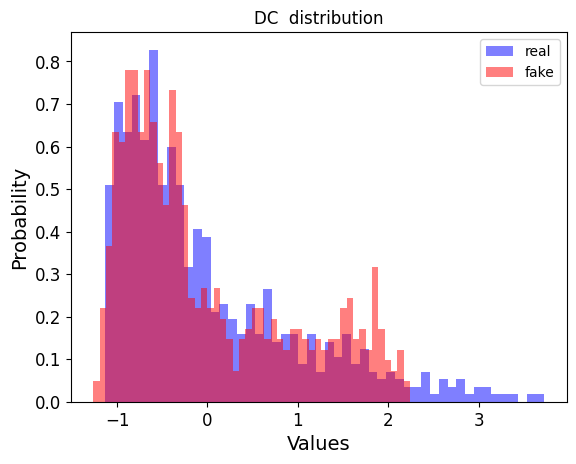

LC


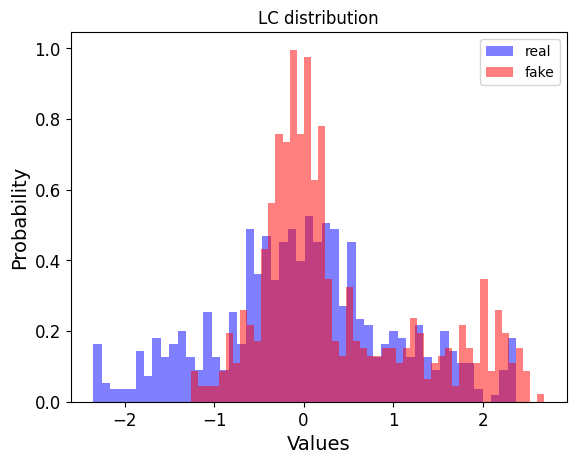

MC


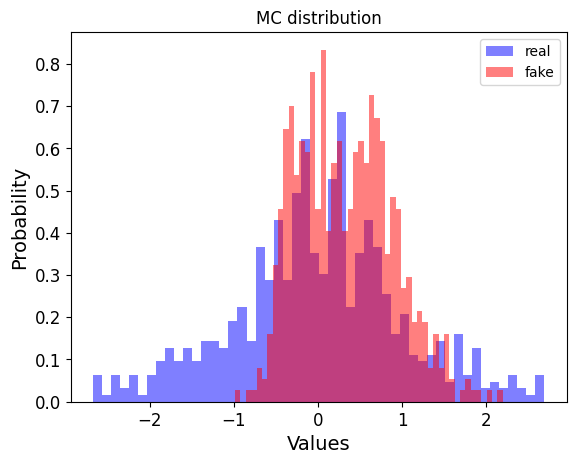

1


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#Load the file
# path = r'C:\Users\Dr.Abbas\OneDrive - National University of Sciences & Technology\Aerodynamics ML data\WGAN_SUBMARINE\fake_data_WGAN'
model_folder = '/content/drive/MyDrive/GAN_NEW/done/'
model_files = os.listdir(model_folder)
classes = list(df)
num=0
for filename in model_files:
    if filename.lower().endswith('.csv'):
      print(filename)
      num+=1
      fakepath = model_folder  + filename
      datafake = pd.read_csv(fakepath)
      for name in classes:
          print (name)
          real_dist = df[name].values
          fake_dist = datafake[name].values
          mse = mean_squared_error(real_dist, fake_dist)
          plt.xlabel('Values')
          plt.ylabel('Probability')
          plt.title(name + " distribution")
          plt.hist(real_dist, 50, density=True, alpha=0.5,facecolor='b', label='real')
          plt.hist(fake_dist, 50, density=True, alpha=0.5, facecolor='r', label='fake')
      #     plt.savefig(str(folder_path) + "/"+ name+'_distribution.png')
          plt.legend()
          plt.show()
          plt.clf()
print(num)